### Imports

In [30]:
import pandas as pd
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning
from pandas import to_datetime
import statsmodels.api as sm
from statsmodels import regression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
import statsmodels.api as sm
import matplotlib.patches as mpatches

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

### Parameters

In [31]:
buy_sell_threshold = 0.15
investment_ratio = 0.00005
long_short_ratio = 0.2
price_cap_lower = 0.5
stop_loss = 2
starting_balance = 1000000
fee = 0.005

run_optimizing = False
google_colab = False

### Data loading

In [32]:
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "1PZQLyOiOpKtLt5BVAvWwQEnxZJzvLcD7"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('Full trading data - All models.csv')  
    df = pd.read_csv('Full trading data - All models.csv')
else:
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
    # Read dataframes using Dask
    df = pd.read_csv(path + '/data/trading/Full trading data - All models - wo missing-filtering.csv')
    df_options = pd.read_csv(path + '/data/processed_data/2011_11feb-2023mar_NSS__wo_moneyness_filtering_BID_ASK.csv')

### Data processing

In [ ]:
# Filter so its just data for 2015
#df = df[(df["Quote_date"] >= "2015-01-01") & (df["Quote_date"] <= "2018-12-31")]
#df = df[(df["Expiry_date"] >= "2015-01-01") & (df["Expiry_date"] <= "2018-12-31")]

# Choos 5% of the data randomly
#df = df.sample(frac=0.1, random_state=1)

In [ ]:
lstm_mlp = True
bs_rolling = False
bs_garch = False
bs_iv = False
heston = False

if lstm_mlp:
    # Out of Quote_date	Expire_date	Price	Bid	Ask	Underlying_last	Strike	TTM	Delta	IV	R	Price_drop	Rolling	GARCH	BS-IV	Heston	LSTM-MLP, drop Rolling, GARCH, BS-IV, Heston
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'LSTM-MLP']]
    # Rename LSTM-MLP to Prediction
    df = df.rename(columns={'LSTM-MLP': 'Prediction'})
elif bs_rolling:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'Rolling']]
    df = df.rename(columns={'Rolling': 'Prediction'})
elif bs_garch:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'GARCH']]
    df = df.rename(columns={'GARCH': 'Prediction'})
elif bs_iv:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'BS-IV']]
    df = df.rename(columns={'BS-IV': 'Prediction'})
elif heston:
    df = df[['Quote_date', 'Expiry_date', 'Price', 'Bid', 'Ask', 'Underlying_last', 'Strike', 'TTM', 'Delta', 'IV', 'R', 'Price_drop', 'Option_ID', 'Heston']]
    df = df.rename(columns={'Heston': 'Prediction'})

In [ ]:
# Remane Expire_date to Expiry_date in df_options
df_options = df_options.rename(columns={'Expire_date': 'Expiry_date'})
df_options["Option_ID"] = df_options["Expiry_date"].astype(str) + "-" + df_options["Strike"].astype(str)
# Filter after 2015
df_options = df_options[(df_options["Quote_date"] >= "2015-01-01")]

In [ ]:
df_combined = pd.merge(df_options, df, how='left', on=['Quote_date', 'Expiry_date', 'Strike', 'Option_ID'])
# Keep only Quote_date, expiry_date, Bid, Ask, Underlying_last and Option_ID from df_options and only the Prediction column from df
df_combined = df_combined[['Quote_date', 'Expiry_date', 'Bid_x', 'Ask_x', 'Underlying_last_x', "Price_x", "Delta_x", "TTM_x", "R_x", 'Option_ID', 'Prediction']]
df_combined = df_combined.rename(columns={'Bid_x': 'Bid', 'Ask_x': 'Ask', 'Underlying_last_x': 'Underlying_last', 'Price_x': 'Price', 'Delta_x': 'Delta', 'TTM_x': 'TTM', 'R_x': 'R'})

# Trading functions

In [ ]:
def generate_buy_sell_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Prediction'] - df['Ask']) / df['Ask'] >= buy_threshold
    sell_signal = (df['Bid'] - df['Prediction']) / df['Bid'] >= sell_threshold
    return buy_signal, sell_signal


def trader(df, buy_signal, sell_signal, starting_balance, price_cap_lower, investment_ratio, long_short_ratio, fee, stop_loss):
    df['Expiry_date'] = pd.to_datetime(df['Expiry_date'])
    df['Quote_date'] = pd.to_datetime(df['Quote_date'])
    df = df[df['Expiry_date'] <= df['Quote_date'].max()]
    
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1

    df['Position_this_opt'] = 0
    df['Balance'] = -1000000    # Makes it easy to spot if balance has not been updated correctly

    df = df.sort_values('Quote_date')
    df['Option_ID'] = df['Option_ID'].astype(str)

    position_dict = {id:0 for id in df['Option_ID'].unique()}
    first_date = df['Quote_date'].min()
    total_balance_dict = {first_date: starting_balance}

    number_of_long_positions = 0
    number_of_short_positions = 0
    entry_prices = {}

    def operation(row):
        nonlocal number_of_long_positions
        nonlocal number_of_short_positions
        if row['Quote_date'] not in total_balance_dict.keys():
            total_balance_dict[row['Quote_date']] = total_balance_dict[max(total_balance_dict.keys())]

        balance = total_balance_dict[row['Quote_date']]
        position = position_dict[row['Option_ID']]

        # If price below cap, do nothing
        if row["Bid"] < price_cap_lower:
            row["Position_this_opt"] = position
            row["Balance"] = balance
            position_dict[row['Option_ID']] = position
            total_balance_dict[row['Quote_date']] = balance
            return row

        # Calculate net ratio
        if number_of_long_positions + number_of_short_positions == 0:
            net_ratio = 0
        else:
            net_ratio = (number_of_long_positions - number_of_short_positions) / (number_of_long_positions + number_of_short_positions)

        # Buy 
        if row['Signal'] == 1 and position <= 0 and row["Quote_date"] != row["Expiry_date"] and balance > 100 and net_ratio < long_short_ratio and row["Ask"] != 0 and row["Prediction"] != np.nan:
            amount_to_invest = balance * investment_ratio
            if amount_to_invest <= balance:
                balance -= amount_to_invest * (1 + fee)
                position += amount_to_invest / row['Ask']
                number_of_long_positions += 1
                entry_prices[row['Option_ID']] = row['Ask']

        # Sell
        elif row['Signal'] == -1 and position >= 0 and row["Quote_date"] != row["Expiry_date"] and balance > 100 and net_ratio > -long_short_ratio and row["Bid"] != 0 and row["Prediction"] != np.nan:
            amount_to_sell = balance * investment_ratio
            balance += amount_to_sell * (1 - fee)
            position -= amount_to_sell / row['Bid']
            number_of_short_positions += 1
            entry_prices[row['Option_ID']] = row['Bid'] 

        # Check if the stop-loss should be triggered
        if row['Option_ID'] in entry_prices:
            entry_price = entry_prices[row['Option_ID']]
            current_price = row['Ask'] if position > 0 else row['Bid']  # Check ask for long and bid for short
            # Long
            if position > 0 and (entry_price - current_price) / entry_price >= stop_loss:
                balance += position * row["Bid"] * (1 - fee) # Sell at bid price
                position = 0
                number_of_long_positions -= 1
                del entry_prices[row['Option_ID']]
            # Short
            elif position < 0 and  (current_price - entry_price) / entry_price >= stop_loss:
                balance -= position * row["Ask"] * (1 + fee) # Buy at ask price
                position = 0
                number_of_short_positions -= 1
                del entry_prices[row['Option_ID']]

        # Expire
        elif row["Quote_date"] == row["Expiry_date"] and position != 0:
            intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
            adjustment = intrinsic_value if position > 0 else -intrinsic_value
            balance += adjustment * abs(position)
            if position < 0:
                number_of_short_positions -= 1
            elif position > 0:
                number_of_long_positions -= 1
            position = 0
        
        
        row['Position_this_opt'] = position
        position_dict[row['Option_ID']] = position
        total_balance_dict[row['Quote_date']] = balance
        row['Balance'] = balance
        return row

    df = df.apply(operation, axis=1)
    df.loc[(df['Position_this_opt'] == 0), 'Balance'] = df['Quote_date'].map(total_balance_dict)
    return df

def calculate_options_value(df):
    df['Options_value'] = 0
    for date in df['Quote_date'].unique():
        # Net value
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
        # Absolute value
        long_options_value_sum = (df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] > 0), 'Position_this_opt'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] > 0), 'Price']).sum()
        short_options_value_sum = (df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] < 0), 'Position_this_opt'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] < 0), 'Price']).sum()
        df.loc[df['Quote_date'] == date, 'Long_options_value'] = long_options_value_sum
        df.loc[df['Quote_date'] == date, 'Short_options_value'] = short_options_value_sum

        # Average delta value of all options combined
        # (position * price * delta) / (position * price)
        long_options_delta_sum = (df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] > 0), 'Position_this_opt'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] > 0), 'Price'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] > 0), 'Delta']).sum()
        short_options_delta_sum = (df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] < 0), 'Position_this_opt'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] < 0), 'Price'] * df.loc[(df['Quote_date'] == date) & (df['Position_this_opt'] < 0), 'Delta']).sum()        
        if long_options_value_sum + short_options_value_sum == 0:
            average_delta = 0
        else:
            average_delta = (long_options_delta_sum + short_options_delta_sum) / (abs(long_options_value_sum) + abs(short_options_value_sum))

        df.loc[df['Quote_date'] == date, 'Average_delta'] = average_delta
    df['Total_value'] = df['Balance'] + df['Options_value']
    return df

### Analysis functions

In [ ]:
def sharpe_ratio(df):
    df_sharpe = df.copy()
    # Make dataframe with 1 month risk free rate
    df_rf = df_sharpe.loc[(df_sharpe["TTM"] >= (25/365)) & (df_sharpe["TTM"] <= (35/365))] 
    df_rf = df_rf.groupby('Quote_date').last()["R"]

    # Original dataframe
    df_group = df.groupby('Quote_date').last()
    df_group["Returns"] = df_group["Total_value"].pct_change().fillna(0)

    # Check for NaN in returns
    print(f"NaN in Returns: {df_group['Returns'].isna().sum()}")

    # Excess returns
    df_group["Excess_Returns"] = df_group["Returns"] - df_rf / 252

    # Check for NaN in excess returns
    print(f"NaN in Excess_Returns: {df_group['Excess_Returns'].isna().sum()}")

    # Check standard deviation of Excess_Returns
    print(f"Standard Deviation of Excess_Returns: {df_group['Excess_Returns'].std()}")

    # Sharpe ratio
    sharpe_ratio = np.sqrt(252) * (df_group["Excess_Returns"].mean() / df_group["Excess_Returns"].std())

    return sharpe_ratio

In [ ]:
def sharpe_ratio_monthly(df):
    df_sharpe = df.copy()
    df_sharpe["YYYY-MM"] = df_sharpe["Quote_date"].dt.strftime("%Y-%m")
    
    # Find the risk-free rate for each month from a row with the same YYYY-MM and TTM close to one month
    df_rf = df_sharpe.loc[(df_sharpe["TTM"] >= (25/365)) & (df_sharpe["TTM"] <= (35/365))]  # Get the rows with TTM close to one month
    df_rf = df_rf.groupby("YYYY-MM").last()["R"]
    
    df_sharpe = df_sharpe.groupby("YYYY-MM").last()
    df_sharpe["Returns"] = df_sharpe["Total_value"].pct_change()
    
    df_sharpe["Excess_Returns"] = df_sharpe["Returns"] - df_rf / 12
    sharpe_ratio = np.sqrt(12) * (df_sharpe["Excess_Returns"].mean() / df_sharpe["Excess_Returns"].std())
    
    return sharpe_ratio

In [ ]:
def sortino_ratio(df):
    df_sharpe = df.copy()
    # Make dataframe with 1 month risk free rate
    df_rf = df_sharpe.loc[(df_sharpe["TTM"] >= (25/365)) & (df_sharpe["TTM"] <= (35/365))] 
    df_rf = df_rf.groupby('Quote_date').last()["R"]

    df_group = df.groupby('Quote_date').last()
    df_group['Excess_Returns'] = df_group['Total_value'].pct_change().fillna(0) - df_rf / 252

    sortino_ratio = np.sqrt(252) * (df_group["Excess_Returns"].mean() / df_group.loc[df_group["Excess_Returns"] < 0, "Excess_Returns"].std())
    return sortino_ratio

In [ ]:
def capm(df_capm):
    df_capm = df_capm.groupby('Quote_date').last()
    df_capm = df_capm[['Total_value', 'Underlying_last']].pct_change()
    
    # For the first day in every year, set the returns to 0
    df_capm['Year'] = df_capm.index.year
    df_capm['First_day_of_year'] = df_capm.groupby('Year')['Total_value'].transform('idxmin')
    df_capm.loc[df_capm.index == df_capm['First_day_of_year'], 'Total_value'] = 0
    df_capm.drop(columns=['Year', 'First_day_of_year'], inplace=True)
    df_capm.dropna(inplace=True)
    
    X = df_capm['Underlying_last']
    y = df_capm['Total_value']

    X = sm.add_constant(X) # Adding a constant term for the intercept in the model

    model = sm.OLS(y, X)
    results = model.fit()

    alpha = results.params['const'] * 252
    beta = results.params['Underlying_last']
    
    # Calculate t-statistics
    t_stats = results.tvalues
    alpha_t_statistic = t_stats['const'] * 252
    beta_t_statistic = t_stats['Underlying_last']

    # Get the p-values
    p_values = results.pvalues
    alpha_p_value = p_values['const']
    beta_p_value = p_values['Underlying_last']

    # Standard Errors
    std_err = results.bse
    alpha_std_err = std_err['const'] * 252
    beta_std_err = std_err['Underlying_last']

    def significance_marker(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    print(f"Alpha: {alpha} SE: {alpha_std_err} p-value: {alpha_p_value} {significance_marker(alpha_p_value)}")
    print(f"Beta: {beta} SE: {beta_std_err} p-value: {beta_p_value} {significance_marker(beta_p_value)}")

    return alpha, beta, alpha_std_err, beta_std_err, alpha_p_value, beta_p_value

In [ ]:
def max_drawdown(df):
    df_group = df.groupby('Quote_date').last()
    df_group['Roll_Max'] = df_group['Total_value'].cummax()
    df_group['Drawdown'] = df_group['Total_value'] / df_group['Roll_Max'] - 1.0
    df_group['Drawdown'].min()
    return df_group['Drawdown'].min() * 100

In [ ]:
def print_results(df, starting_balance):
    ending_balance = df['Balance'].iloc[-1]
    profit = ending_balance - starting_balance
    num_trades = df[df["Price"] > 1]["Signal"].abs().sum()
    profit_per_trade = profit / num_trades

    df['Quote_date'] = pd.to_datetime(df['Quote_date'])
    trading_days = df['Quote_date'].unique().shape[0] - 1
    profit_per_day = profit / trading_days
    num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days

    annualized_return = ((ending_balance / starting_balance)**(365/num_days) - 1)*100

    print(f"Starting balance: {starting_balance}")
    print(f"Ending balance: {ending_balance.round(0)}")
    print(f"Profit: {profit.round(0)}")
    print(f"Profit per trade: {profit_per_trade.round(2)}")
    print(f"Profit per trading day: {profit_per_day.round(2)}")
    print(f"Sharpe ratio: {sharpe_ratio_monthly(df).round(2)}")
    print(f"CAPM alpha: {capm_alpha(df).round(2)}")
    print(f"Annualized return in percent: {annualized_return.round(2)}")
    print(f"Max drawdown: {max_drawdown(df).round(2)}")

In [ ]:
sns.set(style="whitegrid", font='serif', font_scale=1.2)

color = '#1982C4'
color2 = '#FF595E'
color3 = '#8AC926'
color4 = "#FFCA3A"
color5 = "#6A4C93"

def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()

    fig, ax1 = plt.subplots()

    ax1.plot(df['Total_value'], label='Total value', color=color)
    ax1.plot(df['Balance'], label='Cash', color=color2)
    #ax1.plot(df['Options_value'], label='Net value of options', color=color3)
    ax1.plot(df["Long_options_value"], label="Value of long position", color=color5)
    ax1.plot(df["Short_options_value"], label="Value of short position", color=color3)

    # Use gausian filter to smooth delta
    #df['Average_delta'] = gaussian_filter1d(df['Average_delta'], sigma=1)

    # Plot delta on seperate y-axis
    ax2 = ax1.twinx()
    ax2.plot(df['Average_delta'], label='Delta', color=color4) 
    
    ax1.set_title('Portfolio value over time')

    # Make plot smaller
    plt.xticks(rotation=45)

    # Create a legend for all the lines
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    lines = lines1 + lines2
    labels = labels1 + labels2

    ax1.legend(lines, labels, loc=0)
    
    plt.show()

## Run the code

Run by year

In [ ]:
display(df_combined)

,Quote_date,Expiry_date,Bid,Ask,Underlying_last,Price,Delta,TTM,R,Option_ID,Prediction
0,2015-01-02,2015-01-09,1101.50,1113.00,2058.69,1107.250,1.00000,0.019178,0.00020,2015-01-09-950.0,NaN
1,2015-01-02,2015-01-09,1051.50,1063.00,2058.69,1057.250,1.00000,0.019178,0.00020,2015-01-09-1000.0,NaN
2,2015-01-02,2015-01-09,1001.50,1013.00,2058.69,1007.250,1.00000,0.019178,0.00020,2015-01-09-1050.0,NaN
3,2015-01-02,2015-01-09,951.20,962.99,2058.69,957.095,1.00000,0.019178,0.00020,2015-01-09-1100.0,NaN
4,2015-01-02,2015-01-09,901.29,912.99,2058.69,907.140,1.00000,0.019178,0.00020,2015-01-09-1150.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
11683801,2023-03-31,2024-12-20,0.25,1.35,4109.88,0.800,0.00257,1.726027,0.04198,2024-12-20-8400.0,NaN
11683802,2023-03-31,2024-12-20,0.15,1.25,4109.88,0.700,0.00307,1.726027,0.04198,2024-12-20-8600.0,NaN
11683803,2023-03-31,2024-12-20,0.05,1.15,4109.88,0.600,0.00190,1.726027,0.04198,2024-12-20-8800.0,NaN
11683804,2023-03-31,2024-12-20,0.10,1.05,4109.88,0.575,0.00235,1.726027,0.04198,2024-12-20-9000.0,NaN


In [ ]:
# Print number of nan per column
print(df_combined.isna().sum())


Quote_date               0
Expiry_date              0
Bid                      0
Ask                      0
Underlying_last          0
Price                    0
Delta                    0
TTM                      0
R                        0
Option_ID                0
Prediction         1589696
dtype: int64


Alpha: 0.13391620290728523 SE: 0.06980171146563306 p-value: 0.05619274848448107 *
Beta: -0.24471236882005928 SE: 0.028542129955248498 p-value: 1.0942760658169416e-15 ***


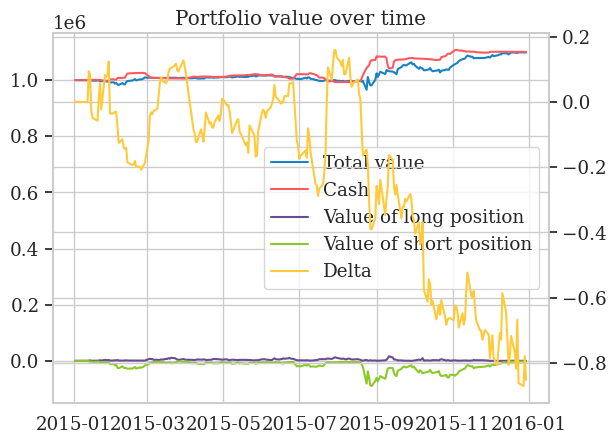

Number of rows in dataframe: 671405 df_sharpe


,Quote_date,Expiry_date,Bid,Ask,Underlying_last,Price,Delta,TTM,R,Option_ID,Prediction,Signal,Position_this_opt,Balance,Options_value,Long_options_value,Short_options_value,Average_delta,Total_value
20125,2015-01-12,2015-03-27,41.29,42.71,2028.56,42.000,0.42129,0.20274,0.00032,2015-03-27-2055.0,40.770054,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20120,2015-01-12,2015-03-27,55.21,56.90,2028.56,56.055,0.49372,0.20274,0.00032,2015-03-27-2030.0,54.632893,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20121,2015-01-12,2015-03-27,52.29,53.90,2028.56,53.095,0.47911,0.20274,0.00032,2015-03-27-2035.0,51.736744,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20122,2015-01-12,2015-03-27,49.40,51.00,2028.56,50.200,0.46545,0.20274,0.00032,2015-03-27-2040.0,48.841747,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20123,2015-01-12,2015-03-27,46.60,48.10,2028.56,47.350,0.45038,0.20274,0.00032,2015-03-27-2045.0,46.086243,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943692,2015-12-30,2015-12-31,469.00,478.10,2063.23,473.550,0.93207,0.00274,0.00080,2015-12-31-1590.0,473.936950,0,0.0,1.100682e+06,-2111.203111,165.452515,-2276.655626,-0.852066,1.098570e+06
943693,2015-12-30,2015-12-31,464.00,473.10,2063.23,468.550,0.93183,0.00274,0.00080,2015-12-31-1595.0,468.954900,0,0.0,1.100682e+06,-2111.203111,165.452515,-2276.655626,-0.852066,1.098570e+06
943694,2015-12-30,2015-12-31,459.00,468.11,2063.23,463.555,0.93258,0.00274,0.00080,2015-12-31-1600.0,463.977940,0,0.0,1.100682e+06,-2111.203111,165.452515,-2276.655626,-0.852066,1.098570e+06
943695,2015-12-30,2015-12-31,454.01,463.09,2063.23,458.550,0.93293,0.00274,0.00080,2015-12-31-1605.0,459.001070,0,0.0,1.100682e+06,-2111.203111,165.452515,-2276.655626,-0.852066,1.098570e+06


Number of rows in risk free dataframe: 33503 df_rf


,Quote_date,Expiry_date,Bid,Ask,Underlying_last,Price,Delta,TTM,R,Option_ID,Prediction,Signal,Position_this_opt,Balance,Options_value,Long_options_value,Short_options_value,Average_delta,Total_value
18936,2015-01-12,2015-02-13,969.09,981.01,2028.56,975.050,1.0,0.087671,0.000195,2015-02-13-1050.0,977.16486,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
18937,2015-01-12,2015-02-13,919.10,931.00,2028.56,925.050,1.0,0.087671,0.000195,2015-02-13-1100.0,927.20575,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
18938,2015-01-12,2015-02-13,869.20,881.00,2028.56,875.100,1.0,0.087671,0.000195,2015-02-13-1150.0,876.93570,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
18939,2015-01-12,2015-02-13,819.19,830.99,2028.56,825.090,1.0,0.087671,0.000195,2015-02-13-1200.0,826.52720,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
18940,2015-01-12,2015-02-13,769.21,781.00,2028.56,775.105,1.0,0.087671,0.000195,2015-02-13-1250.0,776.26697,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873361,2015-12-02,2015-12-31,614.20,630.21,2079.78,622.205,1.0,0.079452,0.001900,2015-12-31-1455.0,624.49316,0,0.0,1.100965e+06,-16340.930816,38.425245,-16379.356061,-0.750636,1.084624e+06
873362,2015-12-02,2015-12-31,609.20,624.70,2079.78,616.950,1.0,0.079452,0.001900,2015-12-31-1460.0,619.52030,0,0.0,1.100965e+06,-16340.930816,38.425245,-16379.356061,-0.750636,1.084624e+06
873363,2015-12-02,2015-12-31,602.00,618.70,2079.78,610.350,1.0,0.079452,0.001900,2015-12-31-1465.0,614.54760,0,0.0,1.100965e+06,-16340.930816,38.425245,-16379.356061,-0.750636,1.084624e+06
873364,2015-12-02,2015-12-31,596.91,615.11,2079.78,606.010,1.0,0.079452,0.001900,2015-12-31-1470.0,609.57477,0,0.0,1.100965e+06,-16340.930816,38.425245,-16379.356061,-0.750636,1.084624e+06


NaN in Returns: 0
NaN in Excess_Returns: 71
Standard Deviation of Excess_Returns: 0.00603109591701499
Sharpe:  1.23
Sortino:  1.67
Number of rows in dataframe: 671405 df_sharpe


,Quote_date,Expiry_date,Bid,Ask,Underlying_last,Price,Delta,TTM,R,Option_ID,Prediction,Signal,Position_this_opt,Balance,Options_value,Long_options_value,Short_options_value,Average_delta,Total_value
20125,2015-01-12,2015-03-27,41.29,42.71,2028.56,42.000,0.42129,0.20274,0.00032,2015-03-27-2055.0,40.770054,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20120,2015-01-12,2015-03-27,55.21,56.90,2028.56,56.055,0.49372,0.20274,0.00032,2015-03-27-2030.0,54.632893,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20121,2015-01-12,2015-03-27,52.29,53.90,2028.56,53.095,0.47911,0.20274,0.00032,2015-03-27-2035.0,51.736744,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20122,2015-01-12,2015-03-27,49.40,51.00,2028.56,50.200,0.46545,0.20274,0.00032,2015-03-27-2040.0,48.841747,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20123,2015-01-12,2015-03-27,46.60,48.10,2028.56,47.350,0.45038,0.20274,0.00032,2015-03-27-2045.0,46.086243,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943692,2015-12-30,2015-12-31,469.00,478.10,2063.23,473.550,0.93207,0.00274,0.00080,2015-12-31-1590.0,473.936950,0,0.0,1.100682e+06,-2111.203111,165.452515,-2276.655626,-0.852066,1.098570e+06
943693,2015-12-30,2015-12-31,464.00,473.10,2063.23,468.550,0.93183,0.00274,0.00080,2015-12-31-1595.0,468.954900,0,0.0,1.100682e+06,-2111.203111,165.452515,-2276.655626,-0.852066,1.098570e+06
943694,2015-12-30,2015-12-31,459.00,468.11,2063.23,463.555,0.93258,0.00274,0.00080,2015-12-31-1600.0,463.977940,0,0.0,1.100682e+06,-2111.203111,165.452515,-2276.655626,-0.852066,1.098570e+06
943695,2015-12-30,2015-12-31,454.01,463.09,2063.23,458.550,0.93293,0.00274,0.00080,2015-12-31-1605.0,459.001070,0,0.0,1.100682e+06,-2111.203111,165.452515,-2276.655626,-0.852066,1.098570e+06


Number of rows in risk free dataframe: 33503 df_rf


,Quote_date,Expiry_date,Bid,Ask,Underlying_last,Price,Delta,TTM,R,Option_ID,Prediction,Signal,Position_this_opt,Balance,Options_value,Long_options_value,Short_options_value,Average_delta,Total_value
18936,2015-01-12,2015-02-13,969.09,981.01,2028.56,975.050,1.0,0.087671,0.000195,2015-02-13-1050.0,977.16486,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
18937,2015-01-12,2015-02-13,919.10,931.00,2028.56,925.050,1.0,0.087671,0.000195,2015-02-13-1100.0,927.20575,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
18938,2015-01-12,2015-02-13,869.20,881.00,2028.56,875.100,1.0,0.087671,0.000195,2015-02-13-1150.0,876.93570,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
18939,2015-01-12,2015-02-13,819.19,830.99,2028.56,825.090,1.0,0.087671,0.000195,2015-02-13-1200.0,826.52720,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
18940,2015-01-12,2015-02-13,769.21,781.00,2028.56,775.105,1.0,0.087671,0.000195,2015-02-13-1250.0,776.26697,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873361,2015-12-02,2015-12-31,614.20,630.21,2079.78,622.205,1.0,0.079452,0.001900,2015-12-31-1455.0,624.49316,0,0.0,1.100965e+06,-16340.930816,38.425245,-16379.356061,-0.750636,1.084624e+06
873362,2015-12-02,2015-12-31,609.20,624.70,2079.78,616.950,1.0,0.079452,0.001900,2015-12-31-1460.0,619.52030,0,0.0,1.100965e+06,-16340.930816,38.425245,-16379.356061,-0.750636,1.084624e+06
873363,2015-12-02,2015-12-31,602.00,618.70,2079.78,610.350,1.0,0.079452,0.001900,2015-12-31-1465.0,614.54760,0,0.0,1.100965e+06,-16340.930816,38.425245,-16379.356061,-0.750636,1.084624e+06
873364,2015-12-02,2015-12-31,596.91,615.11,2079.78,606.010,1.0,0.079452,0.001900,2015-12-31-1470.0,609.57477,0,0.0,1.100965e+06,-16340.930816,38.425245,-16379.356061,-0.750636,1.084624e+06


NaN in Returns: 0
NaN in Excess_Returns: 71
Standard Deviation of Excess_Returns: 0.00603109591701499
Alpha: 0.2621346987167545 SE: 0.06646321403025746 p-value: 0.0001044208031865802 ***
Beta: -0.1478672507734229 SE: 0.03218155388050027 p-value: 6.9121075818086485e-06 ***


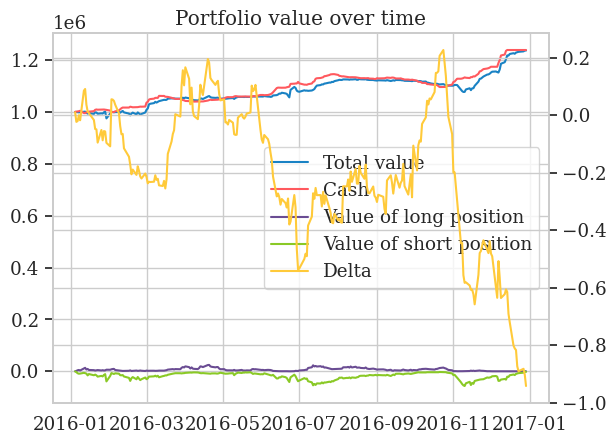

Number of rows in dataframe: 642122 df_sharpe


,Quote_date,Expiry_date,Bid,Ask,Underlying_last,Price,Delta,TTM,R,Option_ID,Prediction,Signal,Position_this_opt,Balance,Options_value,Long_options_value,Short_options_value,Average_delta,Total_value
952963,2016-01-04,2016-03-17,976.00,979.80,2012.98,977.900,1.00000,0.20000,0.002383,2016-03-17-1025.0,980.20920,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
952964,2016-01-04,2016-03-17,951.31,955.29,2012.98,953.300,1.00000,0.20000,0.002383,2016-03-17-1050.0,955.67460,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
952965,2016-01-04,2016-03-17,925.49,930.00,2012.98,927.745,1.00000,0.20000,0.002383,2016-03-17-1075.0,931.02520,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
952966,2016-01-04,2016-03-17,901.20,905.00,2012.98,903.100,1.00000,0.20000,0.002383,2016-03-17-1100.0,906.31840,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
952967,2016-01-04,2016-03-17,876.30,879.90,2012.98,878.100,1.00000,0.20000,0.002383,2016-03-17-1125.0,881.57450,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843583,2016-12-29,2016-12-30,403.20,415.49,2249.28,409.345,0.99861,0.00274,0.003900,2016-12-30-1840.0,409.00037,0,0.0,1.238474e+06,-1978.585042,0.000000,-1978.585042,-0.942415,1.236496e+06
1843584,2016-12-29,2016-12-30,398.20,410.50,2249.28,404.350,0.99833,0.00274,0.003900,2016-12-30-1845.0,403.97930,0,0.0,1.238474e+06,-1978.585042,0.000000,-1978.585042,-0.942415,1.236496e+06
1843585,2016-12-29,2016-12-30,393.20,405.50,2249.28,399.350,0.99883,0.00274,0.003900,2016-12-30-1850.0,398.95822,0,0.0,1.238474e+06,-1978.585042,0.000000,-1978.585042,-0.942415,1.236496e+06
1843562,2016-12-29,2016-12-30,508.20,520.50,2249.28,514.350,0.99870,0.00274,0.003900,2016-12-30-1735.0,513.96450,0,0.0,1.238474e+06,-1978.585042,0.000000,-1978.585042,-0.942415,1.236496e+06


Number of rows in risk free dataframe: 35513 df_rf


,Quote_date,Expiry_date,Bid,Ask,Underlying_last,Price,Delta,TTM,R,Option_ID,Prediction,Signal,Position_this_opt,Balance,Options_value,Long_options_value,Short_options_value,Average_delta,Total_value
951750,2016-01-04,2016-02-05,68.79,70.31,2012.98,69.550,0.65996,0.087671,0.001676,2016-02-05-1970.0,67.380005,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
951751,2016-01-04,2016-02-05,65.41,66.90,2012.98,66.155,0.64352,0.087671,0.001676,2016-02-05-1975.0,63.658504,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
951752,2016-01-04,2016-02-05,62.00,63.40,2012.98,62.700,0.62736,0.087671,0.001676,2016-02-05-1980.0,60.028984,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
951753,2016-01-04,2016-02-05,58.10,59.40,2012.98,58.750,0.61172,0.087671,0.001676,2016-02-05-1985.0,56.441265,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
951754,2016-01-04,2016-02-05,54.80,56.20,2012.98,55.500,0.59513,0.087671,0.001676,2016-02-05-1990.0,52.899273,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768132,2016-12-01,2016-12-30,144.01,153.50,2191.06,148.755,0.92437,0.079452,0.003200,2016-12-30-2045.0,146.117680,0,0.0,1.173895e+06,-22234.747086,140.506631,-22375.253717,-0.481190,1.151660e+06
1768131,2016-12-01,2016-12-30,148.80,158.19,2191.06,153.495,0.92819,0.079452,0.003200,2016-12-30-2040.0,151.066020,0,0.0,1.173895e+06,-22234.747086,140.506631,-22375.253717,-0.481190,1.151660e+06
1768130,2016-12-01,2016-12-30,153.50,163.00,2191.06,158.250,0.93162,0.079452,0.003200,2016-12-30-2035.0,155.986200,0,0.0,1.173895e+06,-22234.747086,140.506631,-22375.253717,-0.481190,1.151660e+06
1768129,2016-12-01,2016-12-30,160.29,167.90,2191.06,164.095,0.92356,0.079452,0.003200,2016-12-30-2030.0,160.732850,0,0.0,1.173895e+06,-22234.747086,140.506631,-22375.253717,-0.481190,1.151660e+06


NaN in Returns: 0
NaN in Excess_Returns: 62
Standard Deviation of Excess_Returns: 0.00440946963020821
Sharpe:  1.62
Sortino:  2.11
Number of rows in dataframe: 642122 df_sharpe


,Quote_date,Expiry_date,Bid,Ask,Underlying_last,Price,Delta,TTM,R,Option_ID,Prediction,Signal,Position_this_opt,Balance,Options_value,Long_options_value,Short_options_value,Average_delta,Total_value
952963,2016-01-04,2016-03-17,976.00,979.80,2012.98,977.900,1.00000,0.20000,0.002383,2016-03-17-1025.0,980.20920,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
952964,2016-01-04,2016-03-17,951.31,955.29,2012.98,953.300,1.00000,0.20000,0.002383,2016-03-17-1050.0,955.67460,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
952965,2016-01-04,2016-03-17,925.49,930.00,2012.98,927.745,1.00000,0.20000,0.002383,2016-03-17-1075.0,931.02520,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
952966,2016-01-04,2016-03-17,901.20,905.00,2012.98,903.100,1.00000,0.20000,0.002383,2016-03-17-1100.0,906.31840,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
952967,2016-01-04,2016-03-17,876.30,879.90,2012.98,878.100,1.00000,0.20000,0.002383,2016-03-17-1125.0,881.57450,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843583,2016-12-29,2016-12-30,403.20,415.49,2249.28,409.345,0.99861,0.00274,0.003900,2016-12-30-1840.0,409.00037,0,0.0,1.238474e+06,-1978.585042,0.000000,-1978.585042,-0.942415,1.236496e+06
1843584,2016-12-29,2016-12-30,398.20,410.50,2249.28,404.350,0.99833,0.00274,0.003900,2016-12-30-1845.0,403.97930,0,0.0,1.238474e+06,-1978.585042,0.000000,-1978.585042,-0.942415,1.236496e+06
1843585,2016-12-29,2016-12-30,393.20,405.50,2249.28,399.350,0.99883,0.00274,0.003900,2016-12-30-1850.0,398.95822,0,0.0,1.238474e+06,-1978.585042,0.000000,-1978.585042,-0.942415,1.236496e+06
1843562,2016-12-29,2016-12-30,508.20,520.50,2249.28,514.350,0.99870,0.00274,0.003900,2016-12-30-1735.0,513.96450,0,0.0,1.238474e+06,-1978.585042,0.000000,-1978.585042,-0.942415,1.236496e+06


Number of rows in risk free dataframe: 35513 df_rf


,Quote_date,Expiry_date,Bid,Ask,Underlying_last,Price,Delta,TTM,R,Option_ID,Prediction,Signal,Position_this_opt,Balance,Options_value,Long_options_value,Short_options_value,Average_delta,Total_value
951750,2016-01-04,2016-02-05,68.79,70.31,2012.98,69.550,0.65996,0.087671,0.001676,2016-02-05-1970.0,67.380005,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
951751,2016-01-04,2016-02-05,65.41,66.90,2012.98,66.155,0.64352,0.087671,0.001676,2016-02-05-1975.0,63.658504,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
951752,2016-01-04,2016-02-05,62.00,63.40,2012.98,62.700,0.62736,0.087671,0.001676,2016-02-05-1980.0,60.028984,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
951753,2016-01-04,2016-02-05,58.10,59.40,2012.98,58.750,0.61172,0.087671,0.001676,2016-02-05-1985.0,56.441265,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
951754,2016-01-04,2016-02-05,54.80,56.20,2012.98,55.500,0.59513,0.087671,0.001676,2016-02-05-1990.0,52.899273,0,0.0,1.000097e+06,-187.767022,187.510392,-375.277413,0.010443,9.999097e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1768132,2016-12-01,2016-12-30,144.01,153.50,2191.06,148.755,0.92437,0.079452,0.003200,2016-12-30-2045.0,146.117680,0,0.0,1.173895e+06,-22234.747086,140.506631,-22375.253717,-0.481190,1.151660e+06
1768131,2016-12-01,2016-12-30,148.80,158.19,2191.06,153.495,0.92819,0.079452,0.003200,2016-12-30-2040.0,151.066020,0,0.0,1.173895e+06,-22234.747086,140.506631,-22375.253717,-0.481190,1.151660e+06
1768130,2016-12-01,2016-12-30,153.50,163.00,2191.06,158.250,0.93162,0.079452,0.003200,2016-12-30-2035.0,155.986200,0,0.0,1.173895e+06,-22234.747086,140.506631,-22375.253717,-0.481190,1.151660e+06
1768129,2016-12-01,2016-12-30,160.29,167.90,2191.06,164.095,0.92356,0.079452,0.003200,2016-12-30-2030.0,160.732850,0,0.0,1.173895e+06,-22234.747086,140.506631,-22375.253717,-0.481190,1.151660e+06


NaN in Returns: 0
NaN in Excess_Returns: 62
Standard Deviation of Excess_Returns: 0.00440946963020821
Alpha: 0.0996273250149858 SE: 0.09985931185813945 p-value: 0.31941641264155096 
Beta: 0.5083411822623904 SE: 0.09417585869386509 p-value: 1.586896346691138e-07 ***


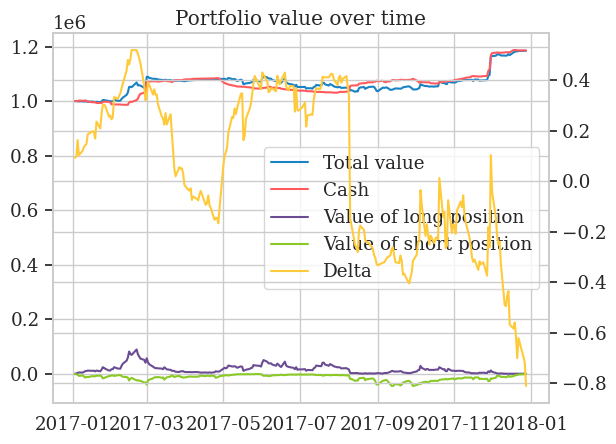

Number of rows in dataframe: 745827 df_sharpe


,Quote_date,Expiry_date,Bid,Ask,Underlying_last,Price,Delta,TTM,R,Option_ID,Prediction,Signal,Position_this_opt,Balance,Options_value,Long_options_value,Short_options_value,Average_delta,Total_value
1852018,2017-01-03,2017-01-04,474.99,486.90,2257.44,480.945,1.00000,0.002740,0.005200,2017-01-04-1775.0,485.33432,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854634,2017-01-03,2017-02-28,894.90,906.71,2257.44,900.805,1.00000,0.153425,0.005181,2017-02-28-1350.0,902.70620,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854635,2017-01-03,2017-02-28,870.00,881.70,2257.44,875.850,1.00000,0.153425,0.005181,2017-02-28-1375.0,877.95060,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854636,2017-01-03,2017-02-28,845.00,856.80,2257.44,850.900,1.00000,0.153425,0.005181,2017-02-28-1400.0,853.19520,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854637,2017-01-03,2017-02-28,820.11,832.10,2257.44,826.105,1.00000,0.153425,0.005181,2017-02-28-1425.0,828.42300,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823365,2017-12-28,2017-12-29,434.30,440.70,2687.17,437.500,0.94405,0.002740,0.011900,2017-12-29-2250.0,438.25450,0,0.0,1.185628e+06,-1107.522768,91.799108,-1199.321876,-0.811605,1.184521e+06
2823366,2017-12-28,2017-12-29,429.29,435.70,2687.17,432.495,0.94469,0.002740,0.011900,2017-12-29-2255.0,433.30377,0,0.0,1.185628e+06,-1107.522768,91.799108,-1199.321876,-0.811605,1.184521e+06
2823367,2017-12-28,2017-12-29,424.30,430.71,2687.17,427.505,0.94535,0.002740,0.011900,2017-12-29-2260.0,428.38785,0,0.0,1.185628e+06,-1107.522768,91.799108,-1199.321876,-0.811605,1.184521e+06
2823358,2017-12-28,2017-12-29,462.20,481.30,2687.17,471.750,1.00000,0.002740,0.011900,2017-12-29-2215.0,473.01038,0,0.0,1.185628e+06,-1107.522768,91.799108,-1199.321876,-0.811605,1.184521e+06


Number of rows in risk free dataframe: 46262 df_rf


,Quote_date,Expiry_date,Bid,Ask,Underlying_last,Price,Delta,TTM,R,Option_ID,Prediction,Signal,Position_this_opt,Balance,Options_value,Long_options_value,Short_options_value,Average_delta,Total_value
1854019,2017-01-03,2017-02-03,60.19,61.49,2257.44,60.840,0.71826,0.084932,0.005174,2017-02-03-2210.0,65.368790,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854020,2017-01-03,2017-02-03,56.60,57.91,2257.44,57.255,0.69806,0.084932,0.005174,2017-02-03-2215.0,61.271145,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854021,2017-01-03,2017-02-03,53.01,53.70,2257.44,53.355,0.67861,0.084932,0.005174,2017-02-03-2220.0,57.097202,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854022,2017-01-03,2017-02-03,49.21,49.89,2257.44,49.550,0.65844,0.084932,0.005174,2017-02-03-2225.0,53.049038,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854023,2017-01-03,2017-02-03,45.60,46.19,2257.44,45.895,0.63606,0.084932,0.005174,2017-02-03-2230.0,49.017242,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745791,2017-11-30,2017-12-29,211.90,224.50,2646.83,218.200,0.90575,0.079452,0.011400,2017-12-29-2435.0,213.099560,0,0.0,1.168191e+06,-4497.162652,12416.242263,-16913.404915,0.102979,1.163693e+06
2745790,2017-11-30,2017-12-29,216.81,229.19,2646.83,223.000,0.90807,0.079452,0.011400,2017-12-29-2430.0,218.050810,0,0.0,1.168191e+06,-4497.162652,12416.242263,-16913.404915,0.102979,1.163693e+06
2745789,2017-11-30,2017-12-29,221.81,234.79,2646.83,228.300,0.90685,0.079452,0.011400,2017-12-29-2425.0,222.925780,0,0.0,1.168191e+06,-4497.162652,12416.242263,-16913.404915,0.102979,1.163693e+06
2745788,2017-11-30,2017-12-29,228.60,234.90,2646.83,231.750,0.91857,0.079452,0.011400,2017-12-29-2420.0,227.803440,0,0.0,1.168191e+06,-4497.162652,12416.242263,-16913.404915,0.102979,1.163693e+06


NaN in Returns: 0
NaN in Excess_Returns: 20
Standard Deviation of Excess_Returns: 0.006777394683369941
Sharpe:  1.52
Sortino:  3.91
Number of rows in dataframe: 745827 df_sharpe


,Quote_date,Expiry_date,Bid,Ask,Underlying_last,Price,Delta,TTM,R,Option_ID,Prediction,Signal,Position_this_opt,Balance,Options_value,Long_options_value,Short_options_value,Average_delta,Total_value
1852018,2017-01-03,2017-01-04,474.99,486.90,2257.44,480.945,1.00000,0.002740,0.005200,2017-01-04-1775.0,485.33432,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854634,2017-01-03,2017-02-28,894.90,906.71,2257.44,900.805,1.00000,0.153425,0.005181,2017-02-28-1350.0,902.70620,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854635,2017-01-03,2017-02-28,870.00,881.70,2257.44,875.850,1.00000,0.153425,0.005181,2017-02-28-1375.0,877.95060,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854636,2017-01-03,2017-02-28,845.00,856.80,2257.44,850.900,1.00000,0.153425,0.005181,2017-02-28-1400.0,853.19520,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854637,2017-01-03,2017-02-28,820.11,832.10,2257.44,826.105,1.00000,0.153425,0.005181,2017-02-28-1425.0,828.42300,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2823365,2017-12-28,2017-12-29,434.30,440.70,2687.17,437.500,0.94405,0.002740,0.011900,2017-12-29-2250.0,438.25450,0,0.0,1.185628e+06,-1107.522768,91.799108,-1199.321876,-0.811605,1.184521e+06
2823366,2017-12-28,2017-12-29,429.29,435.70,2687.17,432.495,0.94469,0.002740,0.011900,2017-12-29-2255.0,433.30377,0,0.0,1.185628e+06,-1107.522768,91.799108,-1199.321876,-0.811605,1.184521e+06
2823367,2017-12-28,2017-12-29,424.30,430.71,2687.17,427.505,0.94535,0.002740,0.011900,2017-12-29-2260.0,428.38785,0,0.0,1.185628e+06,-1107.522768,91.799108,-1199.321876,-0.811605,1.184521e+06
2823358,2017-12-28,2017-12-29,462.20,481.30,2687.17,471.750,1.00000,0.002740,0.011900,2017-12-29-2215.0,473.01038,0,0.0,1.185628e+06,-1107.522768,91.799108,-1199.321876,-0.811605,1.184521e+06


Number of rows in risk free dataframe: 46262 df_rf


,Quote_date,Expiry_date,Bid,Ask,Underlying_last,Price,Delta,TTM,R,Option_ID,Prediction,Signal,Position_this_opt,Balance,Options_value,Long_options_value,Short_options_value,Average_delta,Total_value
1854019,2017-01-03,2017-02-03,60.19,61.49,2257.44,60.840,0.71826,0.084932,0.005174,2017-02-03-2210.0,65.368790,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854020,2017-01-03,2017-02-03,56.60,57.91,2257.44,57.255,0.69806,0.084932,0.005174,2017-02-03-2215.0,61.271145,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854021,2017-01-03,2017-02-03,53.01,53.70,2257.44,53.355,0.67861,0.084932,0.005174,2017-02-03-2220.0,57.097202,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854022,2017-01-03,2017-02-03,49.21,49.89,2257.44,49.550,0.65844,0.084932,0.005174,2017-02-03-2225.0,53.049038,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
1854023,2017-01-03,2017-02-03,45.60,46.19,2257.44,45.895,0.63606,0.084932,0.005174,2017-02-03-2230.0,49.017242,0,0.0,1.000195e+06,-267.071882,387.913212,-654.985093,0.092325,9.999279e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745791,2017-11-30,2017-12-29,211.90,224.50,2646.83,218.200,0.90575,0.079452,0.011400,2017-12-29-2435.0,213.099560,0,0.0,1.168191e+06,-4497.162652,12416.242263,-16913.404915,0.102979,1.163693e+06
2745790,2017-11-30,2017-12-29,216.81,229.19,2646.83,223.000,0.90807,0.079452,0.011400,2017-12-29-2430.0,218.050810,0,0.0,1.168191e+06,-4497.162652,12416.242263,-16913.404915,0.102979,1.163693e+06
2745789,2017-11-30,2017-12-29,221.81,234.79,2646.83,228.300,0.90685,0.079452,0.011400,2017-12-29-2425.0,222.925780,0,0.0,1.168191e+06,-4497.162652,12416.242263,-16913.404915,0.102979,1.163693e+06
2745788,2017-11-30,2017-12-29,228.60,234.90,2646.83,231.750,0.91857,0.079452,0.011400,2017-12-29-2420.0,227.803440,0,0.0,1.168191e+06,-4497.162652,12416.242263,-16913.404915,0.102979,1.163693e+06


NaN in Returns: 0
NaN in Excess_Returns: 20
Standard Deviation of Excess_Returns: 0.006777394683369941


KeyboardInterrupt: 

In [ ]:
if run_optimizing == False:    
    # Initialize an empty DataFrame to store the results
    results = pd.DataFrame(columns=["Year", "Starting balance", "Ending balance", "Profit", "Profit per trade", "Profit per trading day", 
                                    "Sharpe ratio", "Sortino ratio", "Annualized return in percent", "Max drawdown", "CAPM alpha", "CAPM beta", "CAPM alpha p-value", "CAPM beta p-value"])

    # Get the list of years present in the data
    df_combined['Quote_date'] = pd.to_datetime(df_combined['Quote_date'])
    years = df_combined['Quote_date'].dt.year.unique()

    # Sort the years
    years.sort()

    total_dataframe_for_analysis = pd.DataFrame()
    # Iterate over each year
    for year in years:
        df_year = df_combined[df_combined['Quote_date'].dt.year == year].copy()
        
        if not df_year.empty:
            # Execute operations
            buy_signal, sell_signal = generate_buy_sell_signals(df_year, buy_sell_threshold, buy_sell_threshold)
            df_year = trader(df_year, buy_signal, sell_signal, starting_balance, price_cap_lower, investment_ratio, long_short_ratio, fee, stop_loss)
            df_year = calculate_options_value(df_year)

            # Calculate metrics
            ending_balance = df_year['Balance'].iloc[-1]
            profit = ending_balance - starting_balance
            num_trades = df_year[df_year["Price"] > 1]["Signal"].abs().sum()
            profit_per_trade = profit / num_trades

            trading_days = df_year['Quote_date'].unique().shape[0] - 1
            profit_per_day = profit / trading_days
            num_days = (df_year['Quote_date'].max() - df_year['Quote_date'].min()).days

            annualized_return = ((ending_balance / starting_balance)**(365/num_days) - 1)*100

            alpha, beta, alpha_std_err, beta_std_err, alpha_p_value, beta_p_value = capm(df_year)

            plot(df_year)

            # Print number of nan values
            # Drop all rows with nan values
            df_year = df_year.dropna()            
            # Create a DataFrame for this year's metrics
            year_metrics = pd.DataFrame({
                "Year": [year], 
                "Starting balance": [starting_balance], 
                "Ending balance": [ending_balance.round(0)], 
                "Profit": [profit.round(0)], 
                "Profit per trade": [profit_per_trade.round(2)], 
                "Profit per trading day": [profit_per_day.round(2)],
                "Sharpe ratio": [sharpe_ratio(df_year).round(2)],
                "Sortino ratio": [sortino_ratio(df_year).round(2)], 
                "Annualized return in percent": [annualized_return.round(2)], 
                "Max drawdown": [max_drawdown(df_year).round(2)],
                "CAPM alpha": [alpha.round(2)],
                "CAPM beta": [beta.round(2)],
                "CAPM alpha p-value": [alpha_p_value.round(2)],
                "CAPM beta p-value": [beta_p_value.round(2)]
            })
            # Add metrics to the results DataFrame
            results = pd.concat([results, year_metrics])

            total_dataframe_for_analysis = pd.concat([total_dataframe_for_analysis, df_year])

    # Reset index of the results DataFrame
    results.reset_index(drop=True, inplace=True)

    # Print the results DataFrame
    display(results)

In [ ]:
display(total_dataframe_for_analysis)

,Quote_date,Expiry_date,Bid,Ask,Underlying_last,Price,Delta,TTM,R,Option_ID,Prediction,Signal,Position_this_opt,Balance,Options_value,Long_options_value,Short_options_value,Average_delta,Total_value
20125,2015-01-12,2015-03-27,41.29,42.71,2028.56,42.000,0.42129,0.20274,0.00032,2015-03-27-2055.0,40.770054,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20120,2015-01-12,2015-03-27,55.21,56.90,2028.56,56.055,0.49372,0.20274,0.00032,2015-03-27-2030.0,54.632893,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20121,2015-01-12,2015-03-27,52.29,53.90,2028.56,53.095,0.47911,0.20274,0.00032,2015-03-27-2035.0,51.736744,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20122,2015-01-12,2015-03-27,49.40,51.00,2028.56,50.200,0.46545,0.20274,0.00032,2015-03-27-2040.0,48.841747,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
20123,2015-01-12,2015-03-27,46.60,48.10,2028.56,47.350,0.45038,0.20274,0.00032,2015-03-27-2045.0,46.086243,0,0.0,1.000146e+06,-295.688566,277.745936,-573.434501,-0.000768,9.998506e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11669654,2023-03-30,2023-03-31,613.70,616.80,4050.95,615.250,1.00000,0.00274,0.04740,2023-03-31-3435.0,616.627700,0,0.0,1.135842e+06,-2776.092648,17.607753,-2793.700401,-0.756772,1.133066e+06
11669653,2023-03-30,2023-03-31,618.80,621.80,4050.95,620.300,1.00000,0.00274,0.04740,2023-03-31-3430.0,621.603400,0,0.0,1.135842e+06,-2776.092648,17.607753,-2793.700401,-0.756772,1.133066e+06
11669652,2023-03-30,2023-03-31,623.80,626.80,4050.95,625.300,1.00000,0.00274,0.04740,2023-03-31-3425.0,626.579100,0,0.0,1.135842e+06,-2776.092648,17.607753,-2793.700401,-0.756772,1.133066e+06
11669651,2023-03-30,2023-03-31,628.50,631.80,4050.95,630.150,1.00000,0.00274,0.04740,2023-03-31-3420.0,631.554750,0,0.0,1.135842e+06,-2776.092648,17.607753,-2793.700401,-0.756772,1.133066e+06


In [ ]:
# Calculate capm for the total dataframe ignoring the first day of the year each year
alpha, beta, alpha_std_err, beta_std_err, alpha_p_value, beta_p_value = capm(total_dataframe_for_analysis)

Alpha: 0.3436690480591207 SE: 0.06310419305045205 p-value: 5.768864382900336e-08 ***
Beta: 0.04746585501709181 SE: 0.021104685517604832 p-value: 0.024614144958249748 **


In [ ]:
# 

### Post analysis

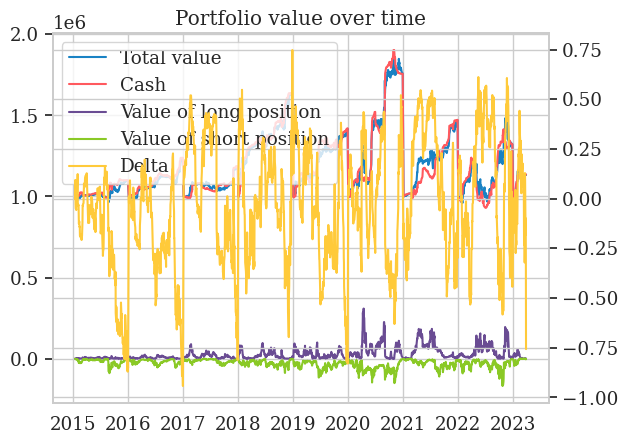

In [ ]:
if run_optimizing == False:
    plot(total_dataframe_for_analysis)

In [ ]:
if google_colab == True:
    if lstm_mlp:
        total_dataframe_for_analysis.to_csv('/content/drive/My Drive/01. Masters Thesis - Shared/07. Trading/Results/LSTM_MLP.csv')
    if bs_rolling:
        total_dataframe_for_analysis.to_csv('/content/drive/My Drive/01. Masters Thesis - Shared/07. Trading/Results/BS_Rolling.csv')
    if bs_garch:
        total_dataframe_for_analysis.to_csv('/content/drive/My Drive/01. Masters Thesis - Shared/07. Trading/Results/BS_GARCH.csv')
    if bs_iv:
        total_dataframe_for_analysis.to_csv('/content/drive/My Drive/01. Masters Thesis - Shared/07. Trading/Results/BS_IV.csv')
    if heston:
        total_dataframe_for_analysis.to_csv('/content/drive/My Drive/01. Masters Thesis - Shared/07. Trading/Results/Heston.csv')

## Threshold search

In [ ]:
if run_optimizing:
    # Initialize wandb
    !pip install wandb
    import wandb
    wandb.login(key="b47bcf387a0571c5520c58a13be35cda8ada0a99")

    # Define the hyperparameters
    sweep_config = {
    'method': 'grid',
    'name': '2015-2018 - v12',
    'metric': {
        'goal': 'maximize', 
        'name': 'alpha'
        },
    'parameters': {
        'buy_threshold': {
            'values': [0.06, 0.1, 0.12]},
        'sell_threshold': {
            'values': [0.06, 0.1, 0.12]},
        'price_cap_lower': {
            'values': [1, 2]},
        'investment_ratio': {
            'values': [5e-4, 5e-5, 5e-6]},
        'long_short_ratio': {
            'values': [0.05, 0.3]}
        }
    }
    sweep_id = wandb.sweep(sweep=sweep_config, project='options-trading') 


In [ ]:
if run_optimizing:
    def find_best_thresholds(df = df):
        run = wandb.init(project = "options-trading")
        df = df.copy()
        buy_signal, sell_signal = generate_buy_sell_signals(df, run.config.buy_threshold, run.config.sell_threshold)
        df = trader(df, buy_signal, sell_signal, starting_balance=100000, price_cap_lower = run.config.price_cap_lower, investment_ratio = run.config.investment_ratio, long_short_ratio = run.config.long_short_ratio)
        df = calculate_options_value(df)
        run.log({"buy_threshold": run.config.buy_threshold, "sell_threshold": run.config.sell_threshold, "sharpe_ratio": sharpe_ratio_monthly(df), "ending_balance": df['Balance'].iloc[-1], "number_of_trades": df['Signal'].abs().sum(), "alpha": capm_alpha(df), "long_short_ratio": run.config.long_short_ratio, "price_cap_lower": run.config.price_cap_lower, "investment_ratio": run.config.investment_ratio})
        # Wandb callback
        print_results(df, 100000)
        plot(df)
        run.finish()

    wandb.agent(sweep_id=sweep_id, function=find_best_thresholds, project='options-trading', count = 1000)